In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(0)
device = "cpu"   # keep consistent with baseline


In [11]:
DATA_DIR = Path("../data")
EXP_DIR = Path("../experiments")
MODEL_DIR = Path("../models")
EXP_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(DATA_DIR, train=True, download=False, transform=transform)
test_set  = datasets.MNIST(DATA_DIR, train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)


## sparse vector, conditional computation and Load balancing

In [12]:
class NoisyTopKRouter(nn.Module):
    def __init__(self, input_dim, num_experts, k=1, noise_std=1.0):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_experts)
        self.k = k
        self.noise_std = noise_std #randomness to explore different experts.
    # Compute raw expert scores for each input.
    def forward(self, x):
        logits = self.linear(x)
    # Add Gaussian noise during training for exploration.
        if self.training:
            logits += torch.randn_like(logits) * self.noise_std
    # Pick the top-K experts for each input
        topk_vals, topk_idx = torch.topk(logits, self.k, dim=-1)

        # sparse vector where only top-K experts have non-zero weights,routing probabilities.
        gates = F.softmax(topk_vals, dim=-1)
        sparse_gates = torch.zeros_like(logits)
        sparse_gates.scatter_(1, topk_idx, gates)

        return sparse_gates, topk_idx


In [13]:
# expert is a small feed-forward network.
class Expert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
    # Processes the input through the expert network.
    def forward(self, x):
        return self.net(x)


SparseMoELayer combines router + experts.

capacity_factor controls max tokens an expert can handle → prevents overload.

In [14]:
class SparseMoELayer(nn.Module):
    def __init__(self, dim, num_experts=4, k=1, capacity_factor=1.25):
        super().__init__()
        self.num_experts = num_experts
        self.k = k
        self.capacity_factor = capacity_factor

        self.router = NoisyTopKRouter(dim, num_experts, k)
        self.experts = nn.ModuleList([Expert(dim) for _ in range(num_experts)])

    # Route each input x through top-K experts.
    def forward(self, x):
        gates, topk_idx = self.router(x)
        batch_size = x.size(0)#extracts the number of inputs in the batch.

        capacity = int(self.capacity_factor * batch_size / self.num_experts)
        output = torch.zeros_like(x)
        load = torch.zeros(self.num_experts, device=x.device)

        active_experts = topk_idx.unique()
        # For each expert, select the inputs assigned to it (mask).Only take capacity number of tokens weights = importance of each token.
        for expert_id in active_experts:
            mask = gates[:, expert_id] > 0
            tokens = x[mask][:capacity]
            weights = gates[mask, expert_id][:tokens.size(0)].unsqueeze(1)

            if tokens.size(0) == 0:
                continue
            # Pass tokens through expert and weight by gate probability.
            expert_out = self.experts[expert_id](tokens)
            output[mask][:tokens.size(0)] += expert_out * weights
            load[expert_id] += tokens.size(0)
            
        # load_loss encourages balanced expert usage → avoids overloading one expert.
        load_dist = load / (load.sum() + 1e-8)
        load_loss = - (load_dist * torch.log(load_dist + 1e-8)).sum()

        return output, load_loss, load_dist


### Input → FC layer → MoE block → Residual add → Output layer

In [15]:
# Flatten MNIST images.
# Apply first linear + ReLU.
# Pass through MoE layer.
# Add MoE output back to main path (residual connection).
# Return logits + load metrics.
class FFN_MoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.moe = SparseMoELayer(256)
        self.fc_out = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        moe_out, load_loss, load_dist = self.moe(x)
        x = x + moe_out
        return self.fc_out(x), load_loss, load_dist


In [18]:
model = FFN_MoE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5
LOAD_LOSS_WEIGHT = 0.01

history = {"loss": [], "acc": [], "load": []}

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_acc = 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        logits, load_loss, load_dist = model(x)
        loss = criterion(logits, y) + LOAD_LOSS_WEIGHT * load_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (logits.argmax(1) == y).float().mean().item()
        history["load"].append(load_dist.cpu())

    history["loss"].append(total_loss / len(train_loader))
    history["acc"].append(total_acc / len(train_loader))

    print(f"Epoch {epoch+1}: Loss={history['loss'][-1]:.4f}, Acc={history['acc'][-1]:.4f}")

Epoch 1: Loss=0.2399, Acc=0.9325
Epoch 2: Loss=0.1055, Acc=0.9716
Epoch 3: Loss=0.0781, Acc=0.9800
Epoch 4: Loss=0.0598, Acc=0.9852
Epoch 5: Loss=0.0494, Acc=0.9885


In [19]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    start = time.time()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _, _ = model(x)
            correct += (logits.argmax(1) == y).sum().item()

    latency = (time.time() - start) / len(loader)
    return correct / len(loader.dataset), latency


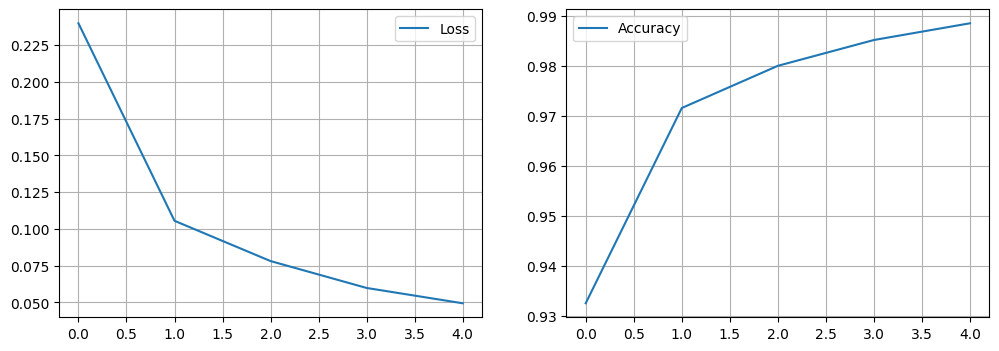

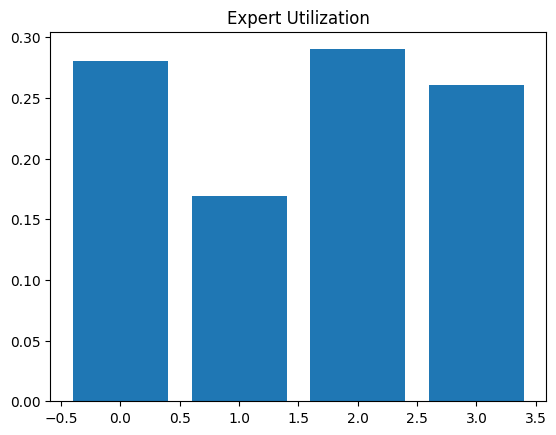

In [20]:
# Training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["loss"], label="Loss")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history["acc"], label="Accuracy")
plt.legend(); plt.grid()
plt.show()

# Expert utilization
load = torch.stack(history["load"]).mean(0)
plt.bar(range(len(load)), load.numpy())
plt.title("Expert Utilization")
plt.show()


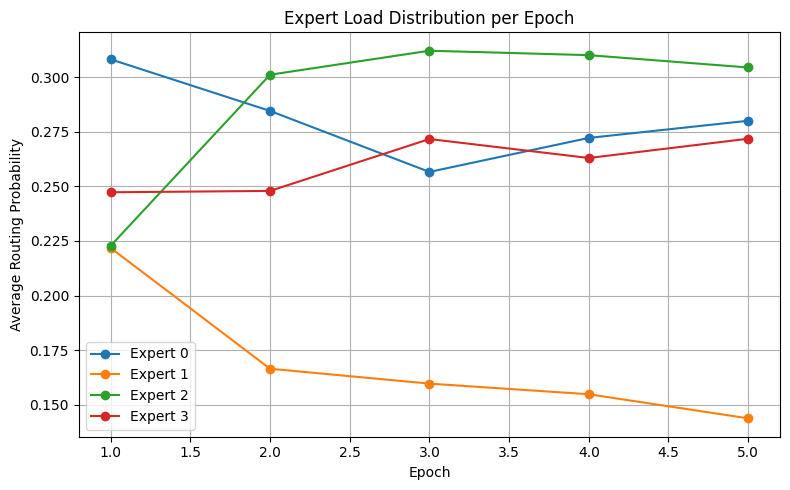

In [21]:
# Stack all load distributions
loads = torch.stack(history["load"])  # shape: [num_batches, num_experts] OR [num_batches, batch, num_experts]

# If load_dist was per-sample, average over batch dimension
if loads.dim() == 3:
    loads = loads.mean(dim=1)  # -> [num_batches, num_experts]

num_experts = loads.size(1)
batches_per_epoch = len(train_loader)
epochs = EPOCHS

# Compute mean expert load per epoch
epoch_loads = []
for e in range(epochs):
    start = e * batches_per_epoch
    end = (e + 1) * batches_per_epoch
    epoch_loads.append(loads[start:end].mean(dim=0))

epoch_loads = torch.stack(epoch_loads)  # [epochs, num_experts]

# Plot
plt.figure(figsize=(8, 5))
for expert_id in range(num_experts):
    plt.plot(
        range(1, epochs + 1),
        epoch_loads[:, expert_id].cpu(),
        marker="o",
        label=f"Expert {expert_id}"
    )

plt.xlabel("Epoch")
plt.ylabel("Average Routing Probability")
plt.title("Expert Load Distribution per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:

# Path to save model
MOE_MODEL_PATH = MODEL_DIR / "sparse_moe_mnist.pth"

# Save model state_dict (recommended for PTQ later)
torch.save(model.state_dict(), MOE_MODEL_PATH)

print(f"Sparse MoE model saved to: {MOE_MODEL_PATH}")

Sparse MoE model saved to: ../models/sparse_moe_mnist.pth


In [23]:
# ===== Final Evaluation =====
test_acc, test_latency = evaluate(model, test_loader)

train_acc = history["acc"][-1]
train_loss = history["loss"][-1]

print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy:  {test_acc:.4f}")
print(f"Avg Inference Latency (per batch): {test_latency:.6f} sec")


Final Train Accuracy: 0.9885
Final Test Accuracy:  0.9787
Avg Inference Latency (per batch): 0.013777 sec


In [24]:
# ===============================
# FINAL: Save Sparse MoE metrics (PARAMETER-BASED SIZE)
# ===============================

import csv

# ----- Parameter-based model size (FP32) -----
num_params = sum(p.numel() for p in model.parameters())
size_MB = num_params * 4 / (1024 ** 2)

print(f"Sparse MoE parameter count: {num_params:,}")
print(f"Sparse MoE parameter-based size: {size_MB:.6f} MB")

csv_path = EXP_DIR / "results.csv"
file_exists = csv_path.exists()

with open(csv_path, mode="a", newline="") as f:
    writer = csv.writer(f)

    if not file_exists:
        writer.writerow([
            "model",
            "test_accuracy",
            "train_accuracy",
            "Loss",
            "Size(M)",
            "Latency(s)"
        ])

    writer.writerow([
        "Sparse_MoE",
        float(test_acc),
        float(train_acc),
        float(train_loss),
        float(size_MB),               # parameter-based
        float(test_latency)
    ])

print(f"Sparse MoE metrics appended to {csv_path}")


Sparse MoE parameter count: 730,894
Sparse MoE parameter-based size: 2.788139 MB
Sparse MoE metrics appended to ../experiments/results.csv
